# Build A Book Recommendation System With Machine Learning

## Project Overview
- **Goals**: Recommend books!
- **Needs**:
    - List of books we like
    - Get recommendations of books that we have not read yet from users who like books that we like.

**Dataset**: [Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

## Project Steps
01. **Search For Books**: Build search engine to find search books on title and find the book ids of the books we like.
02. **Create Book List**: Create a list of book ids of the books that we like
03. **Recommend Books**: Use the list of books we like to recommend that we might like that we haven't read yet. We do that by finding users who like books that we like and what other books that they like. And so we use those books as recommendations that we might like to read.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data = Path("../datasets/")

In [3]:
data_files = list(data.glob("*.csv"))
data_files

[PosixPath('../datasets/Users.csv'),
 PosixPath('../datasets/Ratings.csv'),
 PosixPath('../datasets/Books.csv')]

In [4]:
df_books = pd.read_csv(data / "Books.csv")
df_books.head()

/var/folders/cm/ffpb6rrs0774hy99nscfj5lw0000gn/T/ipykernel_23894/1327942019.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(data / "Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
df_books.shape

(271360, 8)

In [6]:
df_users = pd.read_csv(data / "Users.csv")
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
df_users.shape

(278858, 3)

In [8]:
df_ratings = pd.read_csv(data / "Ratings.csv")
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
df_ratings.shape

(1149780, 3)

### EDA Books Dataframe

In [10]:
df_books.columns = df_books.columns.str.lower().str.replace("-", "_")
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [11]:
# Modify the book title to optimize the search later
# Replace any characters that are not alphanumeric or spaces and lowercase the titles to optimize search
# Replace more spaces with only one space
df_books["mod_title"] = df_books["book_title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
df_books["mod_title"] = df_books["mod_title"].str.lower()
df_books["mod_title"] = df_books["mod_title"].str.replace("\s+", " ", regex=True)

In [12]:
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,mod_title
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,clara callan
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,decision in normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,flu the story of the great influenza pandemic ...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,the mummies of urumchi


### See the shape of the data

In [13]:
df_books.shape

(271360, 9)

### Check column datatypes and any non-value columns

In [14]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   book_author          271359 non-null  object
 3   year_of_publication  271360 non-null  object
 4   publisher            271358 non-null  object
 5   image_url_s          271360 non-null  object
 6   image_url_m          271360 non-null  object
 7   image_url_l          271357 non-null  object
 8   mod_title            271360 non-null  object
dtypes: object(9)
memory usage: 18.6+ MB


In [15]:
df_books.shape

(271360, 9)

In [16]:
df_books["year_of_publication"] = pd.to_datetime(df_books["year_of_publication"], errors="coerce", format="%Y")

In [17]:
df_books.isnull().sum()

isbn                      0
book_title                0
book_author               1
year_of_publication    4623
publisher                 2
image_url_s               0
image_url_m               0
image_url_l               3
mod_title                 0
dtype: int64

In [18]:
df_books.duplicated().sum()

0

In [19]:
df_books.dropna(inplace=True)
df_books["year_of_publication"] = df_books["year_of_publication"].dt.strftime("%Y").astype("int")
df_books.shape

(266734, 9)

### Data Visualization

Histograms for the numerical data

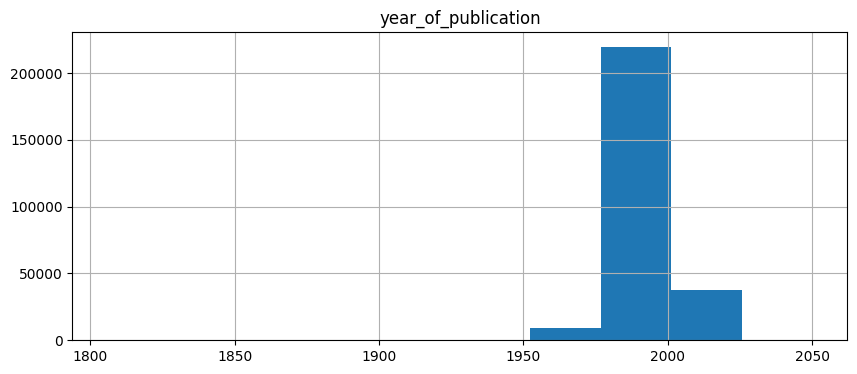

In [20]:
df_books.hist(bins=10, figsize=(10,4))
plt.show()

In [21]:
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,mod_title
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,clara callan
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,decision in normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,flu the story of the great influenza pandemic ...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,the mummies of urumchi


### Building A Book Search Engine for books we like against book titles

#### Terminology

- **Term frequency matrix**: Takes all the unique words across all the titles and each one into a columnar matrix.
- **Inverse Document Frequency Matrix**: Then construct an inverse document frequency matrix. To minimize the impact of very common words.
- **Tfidf matrix**: Tf*idf
- Then find similarity to titles

**Tfidf Concept**

Resources:
- https://www.youtube.com/watch?v=x-alwfgQ-cY
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
- https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df_books["mod_title"])

In [28]:
print(list(df_books["mod_title"].iloc[:20].values))

['classical mythology', 'clara callan', 'decision in normandy', 'flu the story of the great influenza pandemic of 1918 and the search for the virus that caused it', 'the mummies of urumchi', 'the kitchen gods wife', 'what if the worlds foremost military historians imagine what might have been', 'pleading guilty', 'under the black flag the romance and the reality of life among the pirates', 'where youll find me and other stories', 'nights below station street', 'hitlers secret bankers the myth of swiss neutrality during the holocaust', 'the middle stories', 'jane doe', 'a second chicken soup for the womans soul chicken soup for the soul series', 'the witchfinder amos walker mystery series', 'more cunning than man a social history of rats and man', 'goodbye to the buttermilk sky', 'the testament', 'beloved plume contemporary fiction']


#### Turn a search query into vector and match it against the matrix and do a comparison

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import re

In [29]:
query = "The mummies"
processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
query_vec = vectorizer.transform([processed])
similarity = cosine_similarity(query_vec, tfidf).flatten()

In [30]:
similarity

array([0.        , 0.        , 0.        , ..., 0.04975467, 0.        ,
       0.01074744])

In [33]:
## Get the top 10 similarity indices and index them against the titles
indices = np.argpartition(similarity, -10)[-10:]
results = df_books.iloc[indices]

In [34]:
results

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,mod_title
269241,031205131X,Mummies of the Pharaohs: Modern Medical Invest...,Maurice Bucaille,1990,St. Martin's Press,http://images.amazon.com/images/P/031205131X.0...,http://images.amazon.com/images/P/031205131X.0...,http://images.amazon.com/images/P/031205131X.0...,mummies of the pharaohs modern medical investi...
197891,0590448897,101 Wacky Facts About Mummies,Jack C. Harris,1992,Scholastic Paperbacks (Mm),http://images.amazon.com/images/P/0590448897.0...,http://images.amazon.com/images/P/0590448897.0...,http://images.amazon.com/images/P/0590448897.0...,101 wacky facts about mummies
31509,0307264025,Mile 4: Mummies,EDITH KUNHARDT DAVIS,1999,Golden Books,http://images.amazon.com/images/P/0307264025.0...,http://images.amazon.com/images/P/0307264025.0...,http://images.amazon.com/images/P/0307264025.0...,mile 4 mummies
60551,0679824243,"Mummies in the Morning (Magic Tree House, Book 3)",Mary Pope Osborne,1993,Random House Children's Books,http://images.amazon.com/images/P/0679824243.0...,http://images.amazon.com/images/P/0679824243.0...,http://images.amazon.com/images/P/0679824243.0...,mummies in the morning magic tree house book 3
144733,0307201627,Mummies (Totally Weird),Iqbal Hussain,1998,Golden Books,http://images.amazon.com/images/P/0307201627.0...,http://images.amazon.com/images/P/0307201627.0...,http://images.amazon.com/images/P/0307201627.0...,mummies totally weird
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,the mummies of urumchi
174249,0816031088,Encyclopedia of Mummies,Bob Brier,1998,Facts on File,http://images.amazon.com/images/P/0816031088.0...,http://images.amazon.com/images/P/0816031088.0...,http://images.amazon.com/images/P/0816031088.0...,encyclopedia of mummies
245235,0064460118,Mummies Made in Egypt,Aliki,1985,HarperTrophy,http://images.amazon.com/images/P/0064460118.0...,http://images.amazon.com/images/P/0064460118.0...,http://images.amazon.com/images/P/0064460118.0...,mummies made in egypt
253765,0140052666,"Mummies, Death and Life in Ancient Egypt",James Hamilton-Paterson,1979,Penguin USA,http://images.amazon.com/images/P/0140052666.0...,http://images.amazon.com/images/P/0140052666.0...,http://images.amazon.com/images/P/0140052666.0...,mummies death and life in ancient egypt
161987,0448413256,Mummies (All Aboard Reading),Joyce Milton,1996,Grosset &amp; Dunlap,http://images.amazon.com/images/P/0448413256.0...,http://images.amazon.com/images/P/0448413256.0...,http://images.amazon.com/images/P/0448413256.0...,mummies all aboard reading


In [48]:
def make_clickable(val):
    return '<a target="_blank" href="{}">See Image</a>'.format(val)


def show_image(val):
    return '<img src="{}" width=50 />'.format(val)


def search(query, vectorizer):
    processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
    query_vec = vectorizer.transform([processed])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -20)[-20:]
    results = df_books.iloc[indices]
    results = results.sort_values("year_of_publication", ascending=False)  # Get row with the highest year_of_publication
    return results.head(10).style.format({
        "image_url_s": show_image, "image_url_m": make_clickable, "image_url_l": make_clickable
    })

In [56]:
query = "testament"
results = search(query, vectorizer)
results

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,mod_title
185911,0618273530,Testament,Nino Ricci,2003,Houghton Mifflin Company,,See Image,See Image,testament
182247,0874869218,A Third Testament,Malcolm Muggeridge,2002,Plough Publishing House,,See Image,See Image,a third testament
87906,2266110594,Le Testament,John Grisham,2002,Distribooks Inc,,See Image,See Image,le testament
144171,0814625460,Women in the New Testament,Mary Ann Getty-Sullivan,2001,Liturgical Press,,See Image,See Image,women in the new testament
33829,3453190025,Das Testament,John Grisham,2001,Wilhelm Heyne Verlag,,See Image,See Image,das testament
67543,3453173090,Das Testament.,John Grisham,2000,Heyne,,See Image,See Image,das testament
225346,1854790056,Testament: Bible and History,John Romer,1999,Michael O'Mara Books,,See Image,See Image,testament bible and history
949,0385493800,The Testament,John Grisham,1999,Doubleday Books,,See Image,See Image,the testament
4315,0099245027,The Testament,John Grisham,1999,Trafalgar Square,,See Image,See Image,the testament
186707,0805211152,The Testament,Elie Wiesel,1999,Schocken Books,,See Image,See Image,the testament


### Creating a list of isbn of  books that we like

In [57]:
liked_books = ["0596000855", "0596001290", "0072225599", "0618273530", "0814625460"]